# Artificial Neural NetworksAssignment 2
### Comparison between MLP Network with PCA and MLP Network without PCA
<p>This Notebook contains a comparison between MLP network and MLP network after appling PCA on Jm1 Dataset</p>
<br>
<strong>Run the Following Commands before Starting the notebook</strong>

In [1]:
#install dataset that works with imbalanced Data by running the following command
#!pip install -U imbalanced-learn
#!pip install datapackage

**First We Import the Necessary Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import NearMiss

from sklearn import model_selection,preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve,validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,plot_confusion_matrix,precision_recall_fscore_support
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

## Dataset 
**Here the dataset in retrieved from the original website**

In [3]:
# TO load dataset from the orginal website
import datapackage
data_url = 'https://datahub.io/machine-learning/jm1/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        Dataset = pd.read_csv(resource.descriptor['path'])

In [4]:
# Reading the dataset file
Dataset.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17.0,36.0,112.0,86.0,13.0,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17.0,135.0,329.0,271.0,5.0,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11.0,16.0,76.0,50.0,7.0,True


In [5]:
# Checking the  of missing values 
Dataset.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              5
uniq_Opnd            5
total_Op             5
total_Opnd           5
branchCount          5
defects              0
dtype: int64

In [6]:
# Since defects are boolean we need to make it Integer
Dataset.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object

In [7]:
# Converting defect to 1 and 0
Dataset['defects']=Dataset['defects'].astype('int')

In [8]:
# Dealing with missing data by dropping rows with missing values
Dataset.dropna(axis=0,inplace=True)

## Data Visualization

In [9]:
# a code to center the plots this works on jupyter notebook only
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
}
</style>
""")

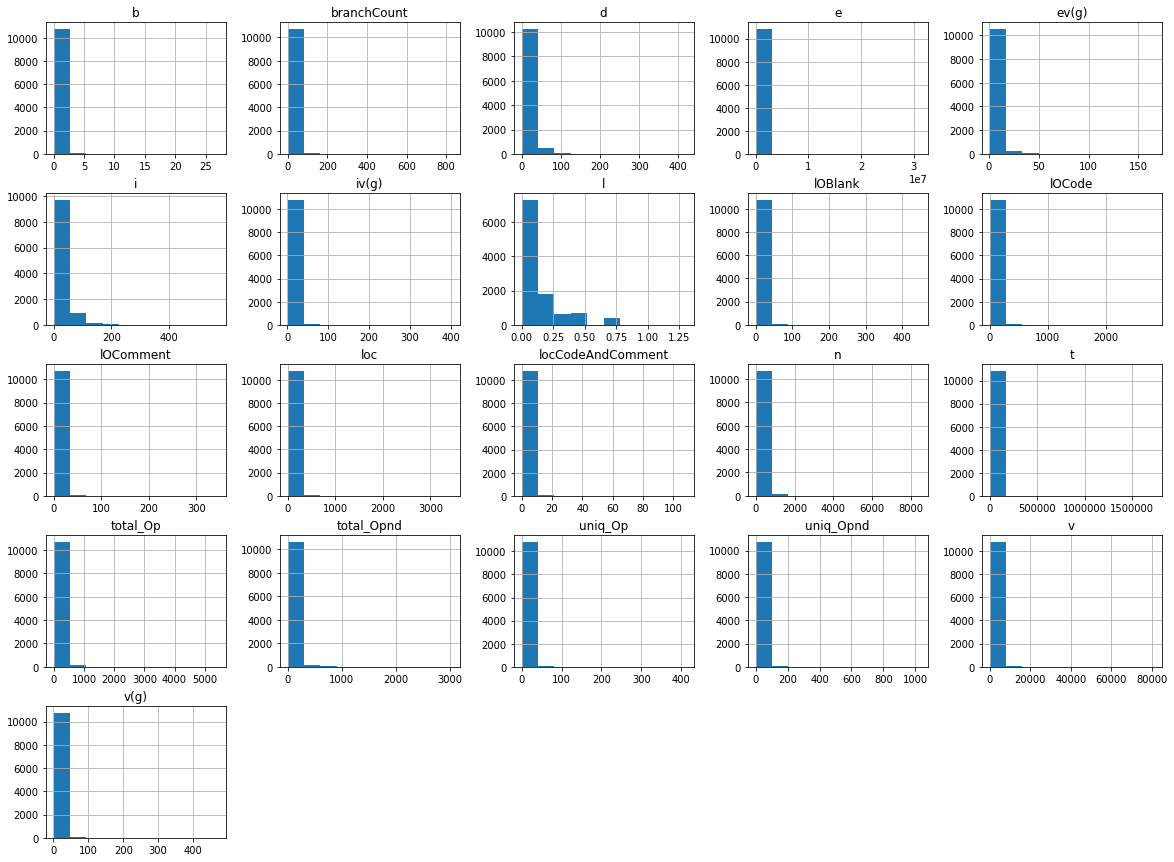

In [10]:
# Ploting the data distrubtion of each feature and target
Dataset.iloc[:,:-1].hist(figsize=(20, 15))
plt.show()

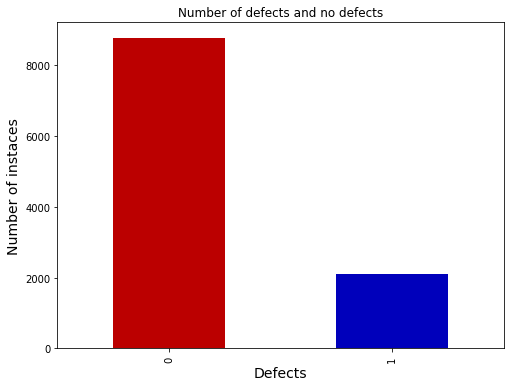

In [11]:
# First step is checking the frequency of each class 
ax=Dataset['defects'].value_counts().plot(kind='bar',color = ['#BB0000', '#0000BB'],
                                          title='Number of defects and no defects',figsize=(8, 6))
ax.set_xlabel("Defects",fontsize=14)
ax.set_ylabel("Number of instaces",fontsize=14)
plt.show()

<h4>As we can see from the figure above that the data is heavily biased with the ratio 80% 20% which is making this dataset un-balanced.</h4>

## Creating the Necessary Functions

**Creating the Model build and Training Function**

In [12]:
#defining the set_seed to 42 to make the results stable with each run
tf.random.set_seed(42)
# Defining Function that builds the model not to repeat it , it returns ths trained model and history of losses and accuaries
def build_Model(act,opti,los,x,y,n_feature=21,ver=0):
    model = Sequential()
    model.add(Dense(1000, input_shape=(n_feature,), activation=act))
    model.add(Dense(500, activation=act))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opti,loss=los,metrics=['accuracy'])
    history =model.fit(x, y, epochs=10, batch_size=250, verbose=ver, validation_split=0.2)
    return [model,history]

**Createing the Model Evaluation Function**
<br>
here we use 2 evaluation metrics to evaluate the model: Accuarcy Score, and Confusion Matrix

In [13]:
# Defining Function that shows the accuracies of models
# It calculates the accuracy, loss and confusion matrix of the model 
def showAcc(model,x_train,y_train,x_test,y_test):
    evaluation=model.evaluate(x_test, y_test,verbose=0)
    print('Neural Network Accuracy is {:.4f}\nNeural Network Loss is {:.4f}'.format(evaluation[1],evaluation[0]))
    y_pred=model.predict(x_test)
    y_pred=(y_pred>0.5)
    cm=confusion_matrix(y_test, y_pred)
    print('True Postive  : '+str(cm[0][0])+'\tFalse Postive  : '+str(cm[0][1]))
    print('False Negative  : '+str(cm[1][0])+'\tTrue Negative  : '+str(cm[1][1]))
    plt.imshow(cm, cmap=plt.cm.Purples,)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Confusion matrix ')
    plt.colorbar()
    plt.show()
    return evaluation

## MLP Before Under-sampling

**Here we try the model on the befor taking any action regarding the un-balanced data we have**

In [14]:
# Dividing the data to training features and target 
x_Dataset=Dataset.iloc[:,:-1]
y_Dataset=Dataset['defects']

In [15]:
# Dividing the data by 0.8 train and 0.2 test
x_train, x_test, y_train, y_test = train_test_split(x_Dataset, y_Dataset, test_size=0.2,random_state=42)
print(x_train.shape, x_test.shape)

(8704, 21) (2176, 21)


In [16]:
# Standardizing the data
sc= StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Neural Network Accuracy is 0.8111
Neural Network Loss is 0.4438
True Postive  : 1717	False Postive  : 40
False Negative  : 371	True Negative  : 48


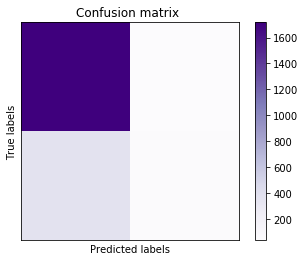

In [17]:
# Building a model to see the first impression 
UnSample=build_Model('sigmoid','adam','binary_crossentropy',x_train,y_train)
UnSample_res=showAcc(UnSample[0],x_train,y_train,x_test,y_test)

**We can see that the accuracy on the validation dataste is 81.1%.**

## Under-sampling the dataset

**Here we try to solve the problem on the un-balanced dataset by performing an unber-sampling technique called NearMiss.**

In [18]:
# Using NearMiss method to undersample the data
sampler = NearMiss(version=1,sampling_strategy={0: 3000,1: 2103})
x_DS, y_DS = sampler.fit_sample(x_Dataset, y_Dataset)

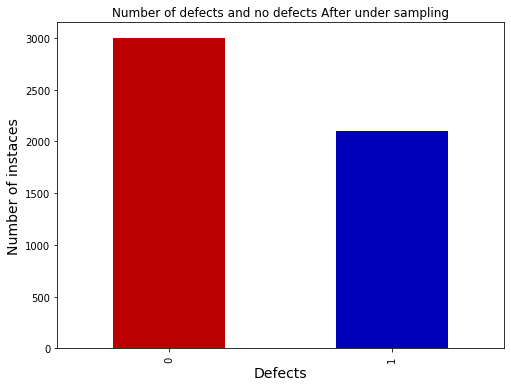

In [19]:
#y_DS = pd.DataFrame(y_DS,columns=['Defects'])
ax=y_DS.value_counts().plot(kind='bar',color = ['#BB0000', '#0000BB'],title='Number of defects and no defects After under sampling',figsize=(8, 6))
ax.set_xlabel("Defects",fontsize=14)
ax.set_ylabel("Number of instaces",fontsize=14)
plt.show()

**Now After the Under-Sampling we can notice the difference in the biasing of the dataset, and it is much better now as the data is more balanced.**

## Data preparation

**Now we operate on the new dataset produced from the under-sampling technique.**

In [20]:
# Splitting the Data
x_train, x_test, y_train, y_test = train_test_split(x_DS, y_DS, test_size=0.2,random_state=42)
print(x_train.shape, x_test.shape)

(4082, 21) (1021, 21)


In [21]:
# Standardization of the data
sc= StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

**Building the same model built before up-sampling to compare the differences.**

Neural Network Accuracy is 0.8962
Neural Network Loss is 0.2904
True Postive  : 594	False Postive  : 12
False Negative  : 94	True Negative  : 321


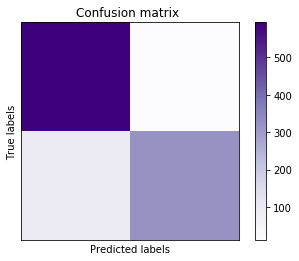

In [22]:
init_MLP=build_Model('sigmoid','adam','binary_crossentropy',x_train,y_train)
res=showAcc(init_MLP[0],x_train,y_train,x_test,y_test)

**As we can see that there is imrovement in the performance of the model.**

## Creating Variations of the Model 

**In this section we try different hyperparameters to create more variations of the MLP model to see the best variation of the network**

### 1) Activation & Optimizer Variations
**In This section , The MLP will be trained by changing the hyperparameters of both activation functions and optimizers to find the best model**

                             MLP With relu Activation Function And Adamax Optimizer                             
Neural Network Accuracy is 0.8874
Neural Network Loss is 0.2761
True Postive  : 582	False Postive  : 24
False Negative  : 91	True Negative  : 324


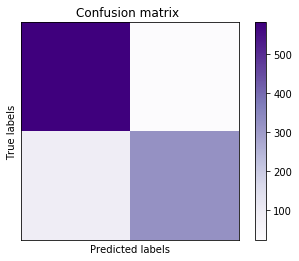

                            MLP With relu Activation Function And RMSprop Optimizer                             
Neural Network Accuracy is 0.8864
Neural Network Loss is 0.2898
True Postive  : 578	False Postive  : 28
False Negative  : 88	True Negative  : 327


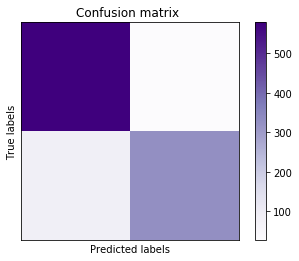

                              MLP With relu Activation Function And Adam Optimizer                              
Neural Network Accuracy is 0.8942
Neural Network Loss is 0.2706
True Postive  : 590	False Postive  : 16
False Negative  : 92	True Negative  : 323


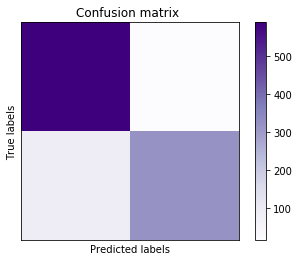

                           MLP With sigmoid Activation Function And Adamax Optimizer                            
Neural Network Accuracy is 0.8874
Neural Network Loss is 0.3233
True Postive  : 591	False Postive  : 15
False Negative  : 100	True Negative  : 315


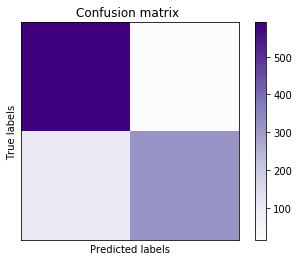

                           MLP With sigmoid Activation Function And RMSprop Optimizer                           
Neural Network Accuracy is 0.8492
Neural Network Loss is 0.3377
True Postive  : 522	False Postive  : 84
False Negative  : 70	True Negative  : 345


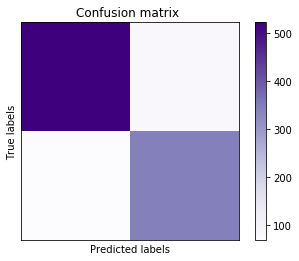

                            MLP With sigmoid Activation Function And Adam Optimizer                             
Neural Network Accuracy is 0.8932
Neural Network Loss is 0.2998
True Postive  : 602	False Postive  : 4
False Negative  : 105	True Negative  : 310


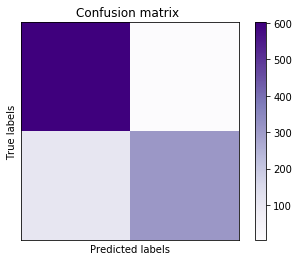

                             MLP With tanh Activation Function And Adamax Optimizer                             
Neural Network Accuracy is 0.8883
Neural Network Loss is 0.2879
True Postive  : 575	False Postive  : 31
False Negative  : 83	True Negative  : 332


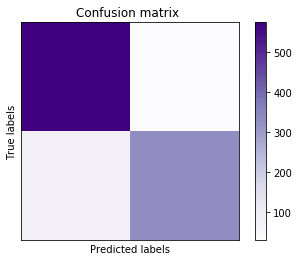

                            MLP With tanh Activation Function And RMSprop Optimizer                             
Neural Network Accuracy is 0.8707
Neural Network Loss is 0.3181
True Postive  : 556	False Postive  : 50
False Negative  : 82	True Negative  : 333


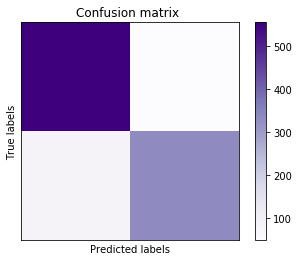

                              MLP With tanh Activation Function And Adam Optimizer                              
Neural Network Accuracy is 0.8932
Neural Network Loss is 0.2771
True Postive  : 584	False Postive  : 22
False Negative  : 87	True Negative  : 328


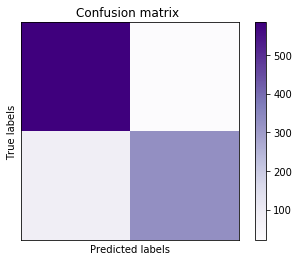

In [23]:
Results=[]
act=['relu','sigmoid','tanh']
opts=['Adamax','RMSprop','Adam']
for  activation in act:
    for optimizer in opts:
        string='\033[1m'+'MLP With '+activation+' Activation Function And '+optimizer+' Optimizer'+"\033[0m"
        print(string.center(120) )
        MLP=build_Model(activation,optimizer,'binary_crossentropy',x_train,y_train)
        res=showAcc(MLP[0],x_train,y_train,x_test,y_test)
        Results.append(res)

**Based On the outputs and confusion matrix we can see that the "ReLU" activation function with adam optimizer produces the best performance model among the variations.**

In [24]:
model_accuracy = pd.DataFrame({
    'MLP': ['Relu', 'Sigmoid', 'Tanh'],
    'Adamax': [Results[x][1] for x in range (0,len(Results),3)],
    'RMSprop': [Results[x][1] for x in range (1,len(Results),3)],
    'Adam' : [Results[x][1] for x in range (2,len(Results),3)],
})
model_accuracy

,MLP,Adamax,RMSprop,Adam
0,Relu,0.887365,0.886386,0.894221
1,Sigmoid,0.887365,0.849167,0.893242
2,Tanh,0.888345,0.870715,0.893242


In [25]:
model_loss = pd.DataFrame({
    'MLP': ['Relu', 'Sigmoid', 'Tanh'],
    'Adamax': [Results[x][0] for x in range (0,len(Results),3)],
    'RMSprop': [Results[x][0] for x in range (1,len(Results),3)],
    'Adam' : [Results[x][0] for x in range (2,len(Results),3)],
})
model_loss

,MLP,Adamax,RMSprop,Adam
0,Relu,0.276057,0.289766,0.270605
1,Sigmoid,0.323323,0.337685,0.299762
2,Tanh,0.287871,0.318093,0.277094


### Building the Best Variation of MLP
**After testing all the variations above, now we build the best MLP variation based on the results we got.**

Neural Network Accuracy is 0.8942
Neural Network Loss is 0.2710
True Postive  : 590	False Postive  : 16
False Negative  : 92	True Negative  : 323


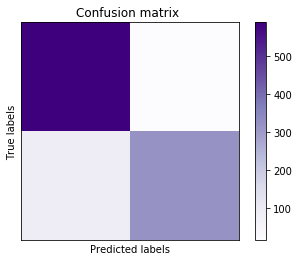

In [26]:
Best_MLP=build_Model('relu','adam','binary_crossentropy',x_train,y_train)
res=showAcc(Best_MLP[0],x_train,y_train,x_test,y_test)

##  Learning Curves
**Now we plot the learning curve for the best MLP variation created above.**

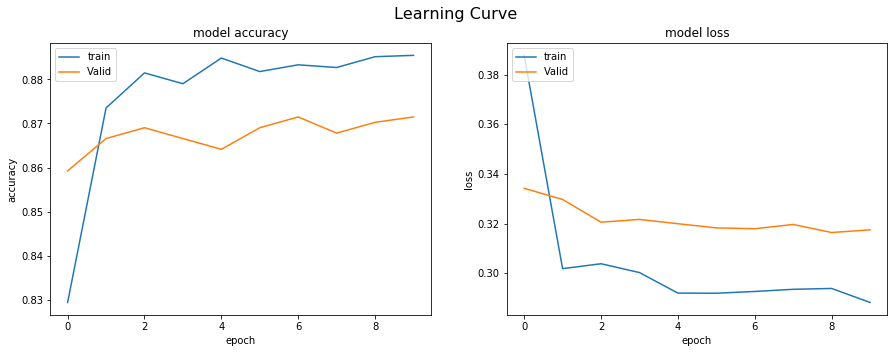

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Learning Curve', fontsize=16)
ax1.plot(Best_MLP[1].history['accuracy'])
ax1.plot(Best_MLP[1].history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'Valid'], loc='upper left')

# summarize history for loss
ax2.plot(Best_MLP[1].history['loss'])
ax2.plot(Best_MLP[1].history['val_loss'])
ax2.set_title('model loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'Valid'], loc='upper left')
plt.show()

## Applying PCA to MLP
**Here we apply PCA method to the MLP network to compare between the enhanced MLP and the basic MLP to see which has the better performance.**
<br>First, we check all the "n_components" values possible to test every variation of PCA.

In [28]:
# We set the parameters of the model to the best variation obtained from the basic MLP variation testing.
Result=[]
for x in range(1,22):
    pca_data = PCA(n_components=x)
    x_trainNew=pca_data.fit_transform(x_train)
    x_testNew=pca_data.transform(x_test)
    MLP=build_Model('relu','adam','binary_crossentropy',x_trainNew,y_train,x,0)
    Result.append(MLP[1])

**Plotting the accuracies in each "n_components" value to see the impact of the PCA.**

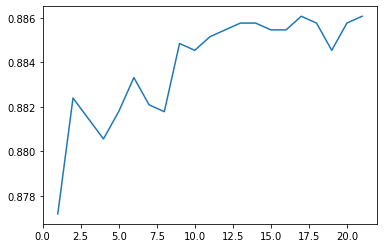

                                            The best result with 16 Features                                            


In [29]:
yTab=[]
xTab=[i for i in range(1,22)]
maxCom=-1
numOfComp=None
for i in range(len(Result)):
    if Result[i].history['accuracy'][-1]>maxCom:
        maxCom=Result[i].history['accuracy'][-1]
        numOfComp=i
    yTab.append(Result[i].history['accuracy'][-1])
plt.plot(xTab,yTab)
plt.show()
print(('The best result with '+str(numOfComp)+' Features').center(120))

**Based on the plot, we can see that we can get the same accuracy of the basic MLP with less features.**
<br> So we create a PCA and setting the "n_components" to the value of numOfComp.

In [30]:
pca_data = PCA(n_components=numOfComp)
x_trainNew2=pca_data.fit_transform(x_train)
x_testNew2=pca_data.transform(x_test)

## Creating Variations of the Model 

**In this section we try different hyperparameters to create more variations of the PCA-MLP model to see the best variation of the network**

### 1) Activation Functions And Optimizer Variation
**In This section , The PCA-MLP will be trained by changing the hyperparameters of both activation functions and optimizers to find the best model**

                           PCA-MLP With relu Activation Function And Adamax Optimizer                           
Neural Network Accuracy is 0.8893
Neural Network Loss is 0.2739
True Postive  : 583	False Postive  : 23
False Negative  : 90	True Negative  : 325


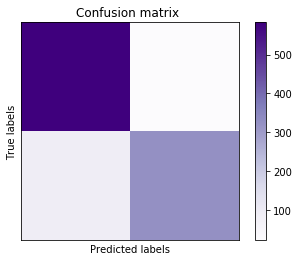

                          PCA-MLP With relu Activation Function And RMSprop Optimizer                           
Neural Network Accuracy is 0.8864
Neural Network Loss is 0.2843
True Postive  : 577	False Postive  : 29
False Negative  : 87	True Negative  : 328


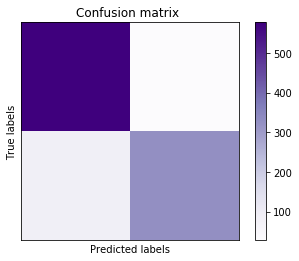

                            PCA-MLP With relu Activation Function And Adam Optimizer                            
Neural Network Accuracy is 0.8942
Neural Network Loss is 0.2698
True Postive  : 589	False Postive  : 17
False Negative  : 91	True Negative  : 324


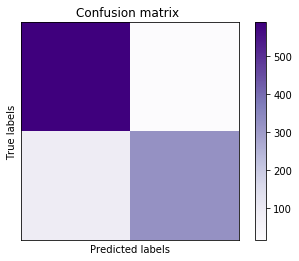

                         PCA-MLP With sigmoid Activation Function And Adamax Optimizer                          
Neural Network Accuracy is 0.8972
Neural Network Loss is 0.3399
True Postive  : 600	False Postive  : 6
False Negative  : 99	True Negative  : 316


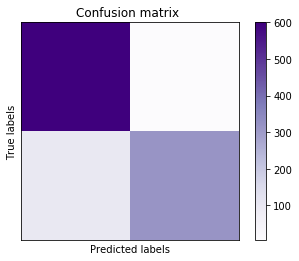

                         PCA-MLP With sigmoid Activation Function And RMSprop Optimizer                         
Neural Network Accuracy is 0.8364
Neural Network Loss is 0.3603
True Postive  : 502	False Postive  : 104
False Negative  : 63	True Negative  : 352


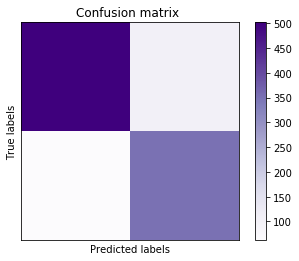

                          PCA-MLP With sigmoid Activation Function And Adam Optimizer                           
Neural Network Accuracy is 0.8903
Neural Network Loss is 0.3015
True Postive  : 597	False Postive  : 9
False Negative  : 103	True Negative  : 312


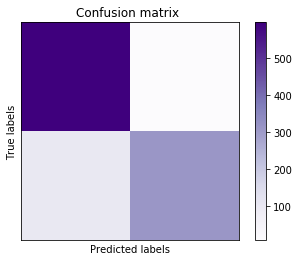

                           PCA-MLP With tanh Activation Function And Adamax Optimizer                           
Neural Network Accuracy is 0.8903
Neural Network Loss is 0.2848
True Postive  : 578	False Postive  : 28
False Negative  : 84	True Negative  : 331


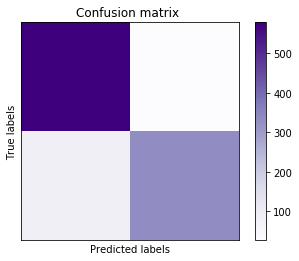

                          PCA-MLP With tanh Activation Function And RMSprop Optimizer                           
Neural Network Accuracy is 0.8707
Neural Network Loss is 0.3175
True Postive  : 556	False Postive  : 50
False Negative  : 82	True Negative  : 333


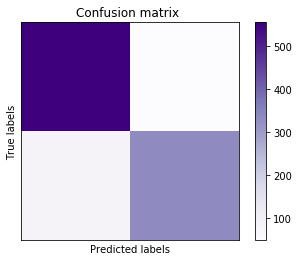

                            PCA-MLP With tanh Activation Function And Adam Optimizer                            
Neural Network Accuracy is 0.8972
Neural Network Loss is 0.2730
True Postive  : 586	False Postive  : 20
False Negative  : 85	True Negative  : 330


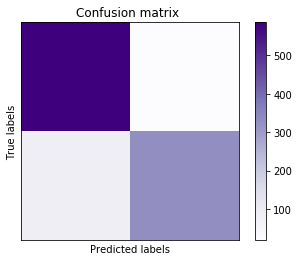

In [31]:
ResultsPCA = []
for  activation in act:
    for optimizer in opts:
        string='\033[1m'+'PCA-MLP With '+activation+' Activation Function And '+optimizer+' Optimizer'+"\033[0m"
        print(string.center(120) )
        MLP_PCA=build_Model(activation,optimizer,'binary_crossentropy',x_trainNew2,y_train,numOfComp,0)
        resPCA=showAcc(MLP_PCA[0],x_trainNew2,y_train,x_testNew2,y_test)
        ResultsPCA.append(resPCA)

**Based On the outputs and confusion matrix we can see that the "Tanh" activation with adam optimizer function produces the best performance among the activation functions.**

In [32]:
model_accuracyPCA = pd.DataFrame({
    'PCA-MLP': ['Relu', 'Sigmoid', 'Tanh'],
    'Adamax': [ResultsPCA[x][1] for x in range (0,len(Results),3)],
    'RMSprop': [ResultsPCA[x][1] for x in range (1,len(Results),3)],
    'Adam' : [ResultsPCA[x][1] for x in range (2,len(Results),3)],
})
model_accuracyPCA

,PCA-MLP,Adamax,RMSprop,Adam
0,Relu,0.889324,0.886386,0.894221
1,Sigmoid,0.897160,0.836435,0.890304
2,Tanh,0.890304,0.870715,0.897160


In [33]:
model_lossPCA = pd.DataFrame({
    'PCA-MLP': ['Relu', 'Sigmoid', 'Tanh'],
    'Adamax': [ResultsPCA[x][0] for x in range (0,len(Results),3)],
    'RMSprop': [ResultsPCA[x][0] for x in range (1,len(Results),3)],
    'Adam' : [ResultsPCA[x][0] for x in range (2,len(Results),3)],
})
model_lossPCA

,PCA-MLP,Adamax,RMSprop,Adam
0,Relu,0.273903,0.284260,0.269752
1,Sigmoid,0.339911,0.360345,0.301549
2,Tanh,0.284850,0.317464,0.273000


### Building the Best Variation of PCA-MLP
**After testing all the variations above, now we build the best PCA-MLP variation based on the results we got.**

Neural Network Accuracy is 0.8962
Neural Network Loss is 0.2729
True Postive  : 585	False Postive  : 21
False Negative  : 85	True Negative  : 330


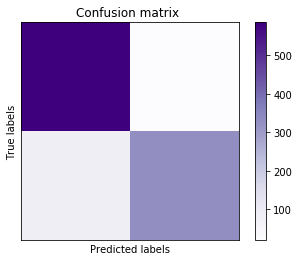

In [34]:
MLP_PCA=build_Model('tanh','adam','binary_crossentropy',x_trainNew2,y_train,numOfComp,0)
PCA_Acc= showAcc(MLP_PCA[0],x_trainNew2,y_train,x_testNew2,y_test)

##  Learning Curves
**Now we plot the learning curve for the best PCA-MLP variation created above.**

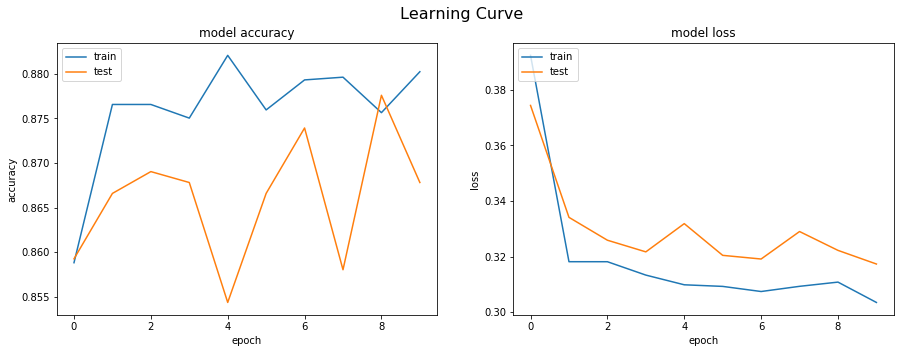

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Learning Curve', fontsize=16)
ax1.plot(MLP_PCA[1].history['accuracy'])
ax1.plot(MLP_PCA[1].history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'Valid'], loc='upper left')

# summarize history for loss
ax2.plot(MLP_PCA[1].history['loss'])
ax2.plot(MLP_PCA[1].history['val_loss'])
ax2.set_title('model loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'Valid'], loc='upper left')
plt.show()

### After Applying PCA to the MLP we obtained slightly better results but with significantly smaller number of features than the basic MLP. So, the "PCA-MLP" considered much better model than the basic MLP.